In [1]:
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
import numpy as np


import pickle
import time
import os


from my_lib.utility import *
from my_lib.tsp_utility import *

# Actividad: Algoritmo genéticos para resolver un problema TSP con restricciones

El problema es de tipo TSP con 18 ciudades Europeas. La diferencia con la actividad anterior radica en la restricción de caminos existentes, pues no todas las ciudades conectan conto todas. Dado el basto espacio de busqueda de la población

> Criterios para la evaluación
>
> - Implementar 2 métodos de cruza, PMX y algún otro método como OX o CX
> - Implementar 2 métodos de mutación, Scramble y Heuristic
> - Implementar un método de selección, cualquiera de los ya vistos
> - Implementar un método hibrido de paro
> - Implementar un méotodo elitista
> - Realizar las comparaciones y la discusión de los resultados

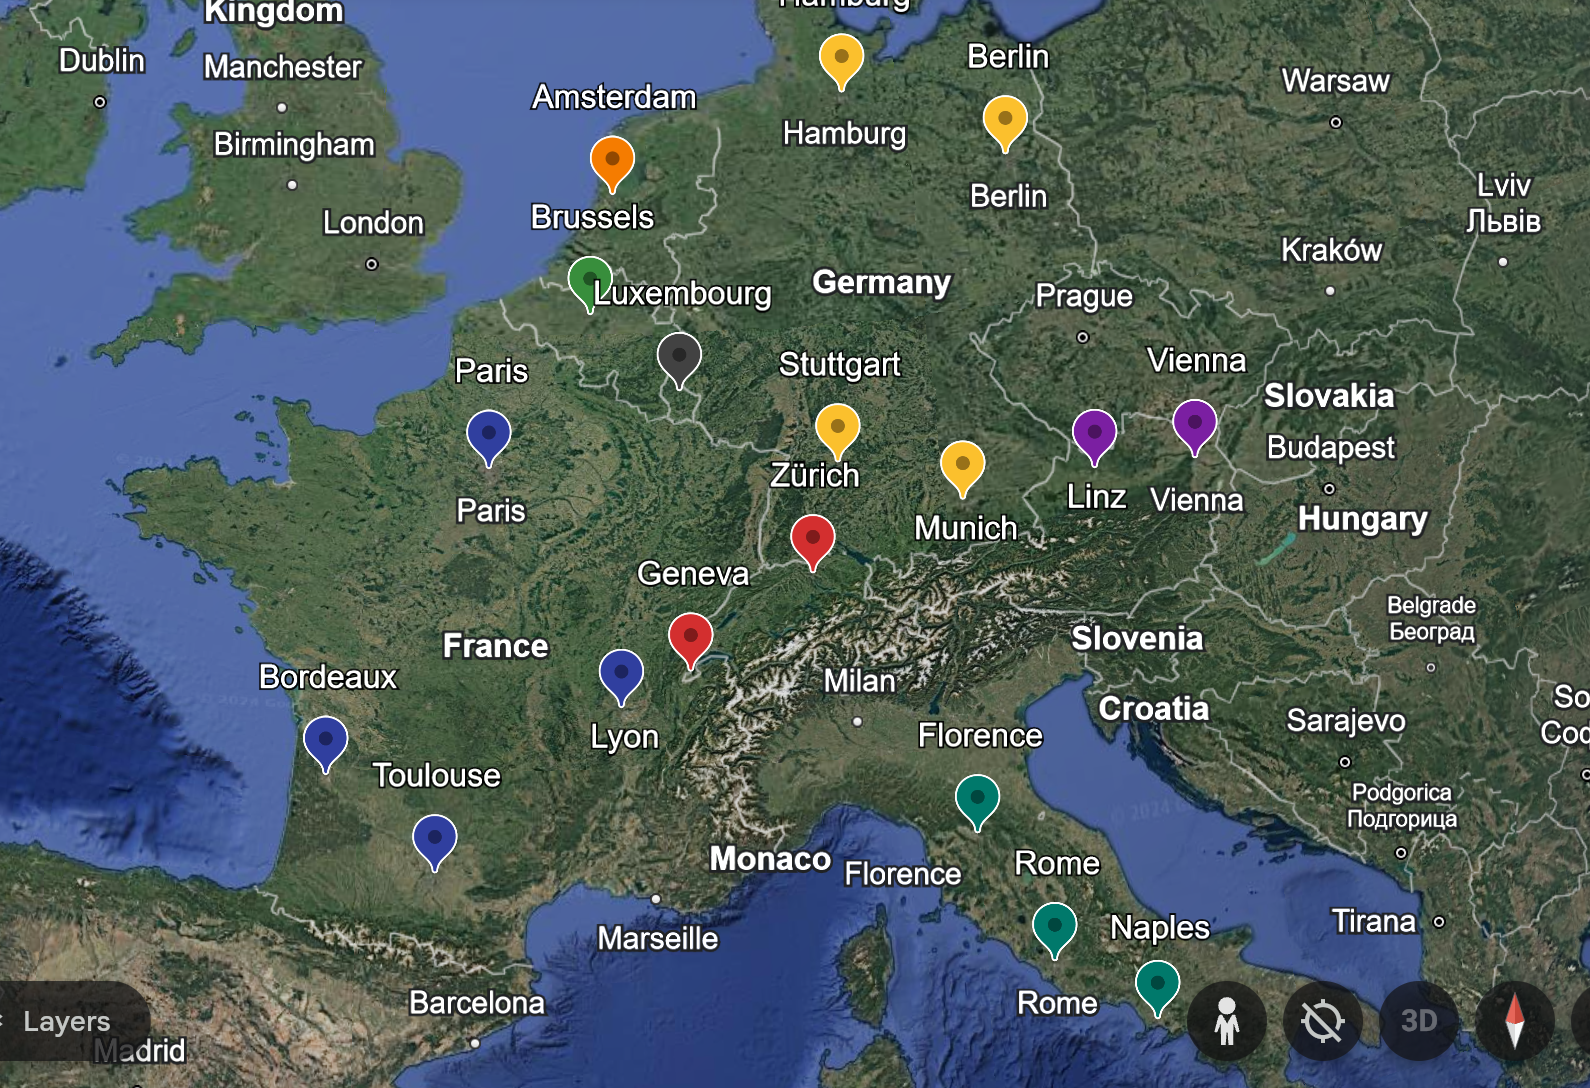


# Codificación del dominio


In [2]:
ciudades_dict = {
    "Ciudad": [
        "Berlin",
        "Hamburg",
        "Stuttgart",
        "Munich",
        "Paris",
        "Lyon",
        "Bordeaux",
        "Toulouse",
        "Amsterdam",
        "Brussels",
        "Luxembourg",
        "Zurich",
        "Geneva",
        "Vienna",
        "Linz",
        "Rome",
        "Florencia",
        "Naples",
    ],
    "Latitud": [
        52.5200066,
        53.5491664,
        48.7758459,
        48.1351253,
        48.8575475,
        45.7640430,
        44.8416106,
        43.6048462,
        52.3675734,
        50.8260453,
        49.8152730,
        47.3768866,
        46.2043907,
        48.2080696,
        48.3069096,
        41.8967068,
        43.7699685,
        40.8517983,
    ],
    "Longitud": [
        13.4049540,
        9.9877451,
        9.1829321,
        11.5819805,
        2.3513765,
        4.8356590,
        -0.5810938,
        1.4428480,
        4.9041389,
        4.3802052,
        6.1295830,
        8.5416940,
        6.1431577,
        16.3713095,
        14.2859180,
        12.4822025,
        11.2576706,
        14.2681200,
    ],
}

In [3]:
fig = go.Figure(
    go.Scattermap(
        lat=ciudades_dict["Latitud"],
        lon=ciudades_dict["Longitud"],
        mode="markers",
        marker=go.scattermap.Marker(size=10),
        text=ciudades_dict["Ciudad"],
    )
)

fig.update_layout(
    title=dict(text="Mapa de ciudades TSP Europa"),
    autosize=True,
    hovermode="closest",
    map=dict(
        bearing=0,
        center=dict(
            lat=47.3768866,
            lon=8.5416940,
        ),
        pitch=0,
        zoom=3.19,
        style="basic",
    ),
)

fig.show()

In [4]:
nombre_ciudades = np.array(ciudades_dict["Ciudad"])
id_ciudades = np.arange(nombre_ciudades.shape[0])

In [5]:
ciudades = np.zeros((nombre_ciudades.shape[0], 2), dtype="object")
ciudades[:, 0] = id_ciudades
ciudades[:, 1] = nombre_ciudades
ciudades

array([[0, 'Berlin'],
       [1, 'Hamburg'],
       [2, 'Stuttgart'],
       [3, 'Munich'],
       [4, 'Paris'],
       [5, 'Lyon'],
       [6, 'Bordeaux'],
       [7, 'Toulouse'],
       [8, 'Amsterdam'],
       [9, 'Brussels'],
       [10, 'Luxembourg'],
       [11, 'Zurich'],
       [12, 'Geneva'],
       [13, 'Vienna'],
       [14, 'Linz'],
       [15, 'Rome'],
       [16, 'Florencia'],
       [17, 'Naples']], dtype=object)

# Calcular matriz de distancias


In [6]:
no_conexiones = [
    (1,7),
    (1,8),
    (1,17),
    (1,18),
    (2,6),
    (2,7),
    (2,8),
    (2,17),
    (2,18),
    (3,9),
    (3,10),
    (3,16),
    (4,7),
    (4,8),
    (4,11),
    (5,15),
    (6,2),
    (6,9),
    (6,14),
    (6,15),
    (7,1),
    (7,2),
    (7,4),
    (7,14),
    (7,18),
    (8,1),
    (8,2),
    (8,4),
    (8,14),
    (8,15),
    (8,16),
    (8,18),
    (9,3),
    (9,6),
    (9,15),
    (9,18),
    (10,3),
    (10,17),
    (10,18),
    (11,4),
    (11,16),
    (11,17),
    (11,18),
    (14,6),
    (14,7),
    (14,8),
    (15,5),
    (15,6),
    (15,8),
    (15,9),
    (15,16),
    (15,18),
    (16,3),
    (16,8),
    (16,11),
    (16,15),
    (17,1),
    (17,2),
    (17,10),
    (17,11),
    (18,1),
    (18,2),
    (18,7),
    (18,8),
    (18,9),
    (18,10),
    (18,11),
    (18,15),
]
fixed_no_conexiones = []
for par in no_conexiones:
    par = par[0] -1,par[1]-1
    fixed_no_conexiones.append(par)
    
no_conexiones = fixed_no_conexiones

In [7]:
n_ciudades = ciudades.shape[0]
distancias = np.zeros((n_ciudades, n_ciudades))


for i in range(n_ciudades):
    c1_latitud = ciudades_dict["Latitud"][i]
    c1_longitud = ciudades_dict["Longitud"][i]
    for j in range(n_ciudades):
        if (i, j) not in no_conexiones:
            c2_latitud = ciudades_dict["Latitud"][j]
            c2_longitud = ciudades_dict["Longitud"][j]
            distancias[j][i] = int(
                get_distancia(
                    lat1=c1_latitud,
                    long1=c1_longitud,
                    lat2=c2_latitud,
                    long2=c2_longitud,
                )
            )

        else:
            distancias[j][i] = np.inf


distancias_df = pd.DataFrame(
    distancias, columns=ciudades_dict["Ciudad"], index=ciudades_dict["Ciudad"]
)
# distancias_df = pd.DataFrame(
#     distancias, columns=np.arange(1,19), index=np.arange(1,19)
# )
display(distancias_df)

Berlin  Hamburg  Stuttgart  Munich   Paris   Lyon  Bordeaux  \
Berlin         0.0    255.0      511.0   504.0   877.0  974.0       inf   
Hamburg      255.0      0.0      533.0   612.0   744.0    inf       inf   
Stuttgart    511.0    533.0        0.0   190.0   500.0  468.0     861.0   
Munich       504.0    612.0      190.0     0.0   684.0  575.0       inf   
Paris        877.0    744.0      500.0   684.0     0.0  391.0     499.0   
Lyon         974.0      inf      468.0   575.0   391.0    0.0     435.0   
Bordeaux       inf      inf      861.0     inf   499.0  435.0       0.0   
Toulouse       inf      inf      827.0     inf   588.0  359.0     211.0   
Amsterdam    576.0    364.0        inf   667.0   429.0    inf     928.0   
Brussels     649.0    487.0        inf   599.0   262.0  563.0     761.0   
Luxembourg   589.0    492.0      249.0     inf   293.0  460.0     748.0   
Zurich       669.0    693.0      162.0   242.0   487.0  335.0     757.0   
Geneva       876.0    861.0      365.0   463.0   409.0  112.0     545.0   
Vienna       523.0    743.0      533.0   355.0  1033.0    inf       inf   
Linz         472.0    655.0      379.0   201.0     inf    inf    1197.0   
Rome        1183.0   1308.0        inf   697.0  1105.0  748.0    1104.0   
Florencia      inf      inf      578.0   486.0   886.0  553.0     948.0   
Naples         inf      inf      967.0   837.0  1291.0  937.0       inf   

            Toulouse  Amsterdam  Brussels  Luxembourg  Zurich  Geneva  Vienna  \
Berlin           inf      576.0     649.0       589.0   669.0   876.0   523.0   
Hamburg          inf      364.0     487.0       492.0   693.0   861.0   743.0   
Stuttgart      827.0        inf       inf       249.0   162.0   365.0   533.0   
Munich           inf      667.0     599.0         inf   242.0   463.0   355.0   
Paris          588.0      429.0     262.0       293.0   487.0   409.0  1033.0   
Lyon           359.0        inf     563.0       460.0   335.0   112.0     inf   
Bordeaux       211.0      928.0     761.0       748.0   757.0   545.0     inf   
Toulouse         0.0     1007.0     832.0       777.0   693.0   469.0     inf   
Amsterdam     1007.0        0.0     175.0       296.0   612.0   691.0   935.0   
Brussels       832.0      175.0       0.0       167.0   488.0   530.0   912.0   
Luxembourg     777.0      296.0     167.0         0.0   323.0   401.0   767.0   
Zurich         693.0      612.0     488.0       323.0     0.0   224.0   591.0   
Geneva         469.0      691.0     530.0       401.0   224.0     0.0   803.0   
Vienna           inf      935.0     912.0       767.0   591.0   803.0     0.0   
Linz             inf        inf     766.0       617.0   440.0   657.0   154.0   
Rome             inf     1296.0    1169.0         inf   684.0   696.0   765.0   
Florencia      788.0     1065.0       inf         inf   453.0   484.0   631.0   
Naples           inf        inf       inf         inf   857.0   884.0   834.0   

              Linz    Rome  Florencia  Naples  
Berlin       472.0  1183.0        inf     inf  
Hamburg      655.0  1308.0        inf     inf  
Stuttgart    379.0     inf      578.0   967.0  
Munich       201.0   697.0      486.0   837.0  
Paris          inf  1105.0      886.0  1291.0  
Lyon           inf   748.0      553.0   937.0  
Bordeaux    1197.0  1104.0      948.0     inf  
Toulouse       inf     inf      788.0     inf  
Amsterdam      inf  1296.0     1065.0     inf  
Brussels     766.0  1169.0        inf     inf  
Luxembourg   617.0     inf        inf     inf  
Zurich       440.0   684.0      453.0   857.0  
Geneva       657.0   696.0      484.0   884.0  
Vienna       154.0   765.0      631.0   834.0  
Linz           0.0     inf      555.0     inf  
Rome           inf     0.0      230.0   188.0  
Florencia    555.0   230.0        0.0   408.0  
Naples         inf   188.0      408.0     0.0

# Función objetivo


In [8]:
def y(ciudad1, ciudad2):
    return distancias[ciudad1, ciudad2]


def evaluar(poblacion):
    evaluacion = np.zeros((poblacion.shape[0]))
    for idx, fila in enumerate(poblacion):
        individuo = fila[0]
        n = len(individuo)
        aptitud = 0
        for i in range(n):
            c1 = int(individuo[i])
            c2 = individuo[i + 1] if not (i + 1 == n) else individuo[0]
            aux = y(c1, c2)
            distancia = aux if aux != np.inf else 1e10
            aptitud += distancia

        evaluacion[idx] = np.around(aptitud, 4)

    return evaluacion


def validar_cromosoma(cromosoma):
    ruta = cromosoma.copy()
    n = len(ruta)
    for i in range(n):
        idx = i
        idx2 = i + 1 if not (i + 1 >= n) else 0
        escala = [ruta[idx], ruta[idx2]]

        if (escala[0], escala[1]) in no_conexiones:
            # Seleccionar que ciudad del par no valido se cambiara por otra
            # print(f"{ruta[idx]} --> {ruta[idx2]} Distancia : {y(ruta[idx],ruta[idx2])}")

            # Ciudad a modificar
            escala_idx = 0 if np.random.randint(0, 2) == 1 else 1
            ciudades_revisadas = set(escala)
            while True:
                # Buscar ciudades válidas que no estén en el par original
                ciudades_filtradas = ciudades[:, 0][
                    ~np.isin(ciudades[:, 0], list(ciudades_revisadas))
                ]
                if len(ciudades_filtradas) == 0:
                    print("No hay más ciudades válidas para probar.")
                    break

                # Seleccionar una ciudad al azar de las posibles
                aux = np.random.choice(ciudades_filtradas)
                # posición en la ruta de la nueva ciudad
                aux_idx = np.where(ruta == aux)[0][0]
                # print(f"Cambiar de lugar la ciudad {escala[escala_idx]} por {aux}")

                # Guardar la escala previa
                prev_escala = escala[escala_idx]
                escala[escala_idx] = aux
                ciudades_revisadas.add(aux)

                # Verificar que la escala nueva sea valida
                if not (escala[0], escala[1]) in no_conexiones:
                    ruta[idx] = escala[0]
                    ruta[idx2] = escala[1]
                    ruta[aux_idx] = prev_escala

                    aux_prev_idx = aux_idx - 1 if (aux_idx > 0) else n - 1
                    aux_next_idx = aux_idx + 1 if (aux_idx < n - 1) else 0

                    # Validar que el intercambio no rompa la armonía
                    if ((ruta[aux_prev_idx], ruta[aux_idx]) in no_conexiones) or (
                        (ruta[aux_idx], ruta[aux_next_idx]) in no_conexiones
                    ):
                        # Revertir si intercambio de ciudades produce errores
                        escala[escala_idx] = prev_escala
                        ruta[idx] = escala[0]
                        ruta[idx2] = escala[1]
                        ruta[aux_idx] = aux
                        # print("El intercambio de ciudades produce errores")
                        continue
                    else:
                        # print("Cambio valido")
                        break
                else:
                    # print(f"{escala} no es valida")
                    escala[escala_idx] = prev_escala
    return ruta

# Generación de población incial


In [9]:
POBS_DIR = "..\\files\\act4\\pobs\\"
if not os.path.isdir(POBS_DIR):
    os.makedirs(POBS_DIR)

In [10]:
numero_de_poblaciones_iniciales = 10
tam_pob = 200
pobs_iniciales = get_poblaciones_iniciales(
    n=numero_de_poblaciones_iniciales,
    tam_pob=tam_pob,
    pob_dir=POBS_DIR,
    funcion_evaluar=evaluar,
    ciudades=ciudades,
    funcion_validar=validar_cromosoma,
)

Archivo de poblaciones cargado correctamente


In [11]:
intial_stats(
    pobs_iniciales,
    f"Estadísticas de las {numero_de_poblaciones_iniciales} poblaciones con {tam_pob} individuos",
)

# Sampling de una ruta al azar


In [12]:
def graficar_ruta(ruta):
    n = len(ruta)
    latitud = []
    longitud = []
    nombres = []
    lineas = []
    distancias = []

    for i in range(n):
        latitud.append(ciudades_dict["Latitud"][ruta[i]])
        longitud.append(ciudades_dict["Longitud"][ruta[i]])
        nombres.append(ciudades_dict["Ciudad"][ruta[i]])

        # Obtener la ciudad actual y la siguiente
        ni = i + 1 if (i + 1 < n) else 0
        current_city = ruta[i]
        next_city = ruta[ni]

        # Calcular la distancia (aquí se debe definir la función y)
        distancia = y(current_city, next_city)
        distancia = distancia if distancia != np.inf else 1e10
        print(
            f"{ciudades[current_city]} ----> {ciudades[next_city]} | Distancia: {distancia}"
        )
        # Agregar la distancia a la lista
        distancias.append(distancia)

        # Guardar las coordenadas de las líneas
        lineas.append(
            (
                latitud[i],
                longitud[i],
                ciudades_dict["Latitud"][ruta[ni]],
                ciudades_dict["Longitud"][ruta[ni]],
            )
        )

    print(f"Aptitud total: {np.sum(distancias)}")
    # Crear un mapa
    fig = go.Figure()

    # Agregar puntos de las ciudades
    fig.add_trace(
        go.Scattergeo(
            lat=latitud,
            lon=longitud,
            text=nombres,
            mode="markers+text",
            marker=dict(size=10, color="blue"),
        )
    )

    # Agregar líneas entre las ciudades
    for i, (lat1, lon1, lat2, lon2) in enumerate(lineas):
        fig.add_trace(
            go.Scattergeo(
                lat=[lat1, lat2],
                lon=[lon1, lon2],
                mode="lines",
                line=dict(width=2, color="red"),
                hoverinfo="text",
                text=f"Distancia: {distancias[i]:.2f} unidades",
            )
        )

    # Actualizar el diseño del mapa
    fig.update_layout(
        title=f"Ruta de Ciudades {nombres[0]} a {nombres[-1]}",
        geo=dict(
            resolution=110,
            showland=True,
            landcolor="lightgray",
            countrycolor="black",
            projection_type="azimuthal equal area",
        ),
    )

    # Mostrar el mapa
    fig.show()

In [13]:
idx_random = np.random.choice(pobs_iniciales[1].shape[0])
ruta_random = pobs_iniciales[1][idx_random][0]
print(f"aptitud: {pobs_iniciales[1][idx_random][3]}")
graficar_ruta(ruta_random)

aptitud: 11121.0
[14 'Linz'] ----> [11 'Zurich'] | Distancia: 440.0
[11 'Zurich'] ----> [8 'Amsterdam'] | Distancia: 612.0
[8 'Amsterdam'] ----> [10 'Luxembourg'] | Distancia: 296.0
[10 'Luxembourg'] ----> [7 'Toulouse'] | Distancia: 777.0
[7 'Toulouse'] ----> [6 'Bordeaux'] | Distancia: 211.0
[6 'Bordeaux'] ----> [15 'Rome'] | Distancia: 1104.0
[15 'Rome'] ----> [17 'Naples'] | Distancia: 188.0
[17 'Naples'] ----> [5 'Lyon'] | Distancia: 937.0
[5 'Lyon'] ----> [9 'Brussels'] | Distancia: 563.0
[9 'Brussels'] ----> [13 'Vienna'] | Distancia: 912.0
[13 'Vienna'] ----> [2 'Stuttgart'] | Distancia: 533.0
[2 'Stuttgart'] ----> [16 'Florencia'] | Distancia: 578.0
[16 'Florencia'] ----> [4 'Paris'] | Distancia: 886.0
[4 'Paris'] ----> [3 'Munich'] | Distancia: 684.0
[3 'Munich'] ----> [1 'Hamburg'] | Distancia: 612.0
[1 'Hamburg'] ----> [0 'Berlin'] | Distancia: 255.0
[0 'Berlin'] ----> [12 'Geneva'] | Distancia: 876.0
[12 'Geneva'] ----> [14 'Linz'] | Distancia: 657.0
Aptitud total: 11121.0

# Eficacia de la validación de cromosomas


In [14]:
def show_validez(pobs_iniciales):
    tam_pob = pobs_iniciales[0].shape[0]
    pob_names = np.zeros(len(pobs_iniciales), dtype="object")
    for i, _ in enumerate(pob_names):
        pob_names[i] = f"Población {i+1}"

    umbral = 1e10
    porcentaje = np.zeros((len(pobs_iniciales), 2))
    for i, pi in enumerate(pobs_iniciales):
        for individuo in pi:
            aptitud = individuo[3]
            if aptitud >= umbral:
                porcentaje[i, 0] += 1
            else:
                porcentaje[i, 1] += 1

    porcentaje_total = np.array([np.sum(porcentaje[:, 0]), np.sum(porcentaje[:, 1])])
    total_pob = np.sum(porcentaje_total)
    # Calcular el porcentaje
    porcentaje[:, 0] = (
        porcentaje[:, 0] / tam_pob
    ) * 100  # Porcentaje de aptitud >= umbral
    porcentaje[:, 1] = (
        porcentaje[:, 1] / tam_pob
    ) * 100  # Porcentaje de aptitud < umbral
    # porcentaje_total[0] = (porcentaje_total[0]/total_pob) * 100
    # porcentaje_total[1] = (porcentaje_total[1]/total_pob) * 100
    fig = go.Figure()

    fig.add_trace(
        go.Bar(
            name="Con rutas validas",
            x=pob_names,
            y=porcentaje[:, 1],
            marker_color="rgb(129, 200, 190)",
        ),
    )

    fig.add_trace(
        go.Bar(
            name="Con rutas no validas",
            x=pob_names,
            y=porcentaje[:, 0],
            marker_color="rgb(239, 159, 118)",
        ),
    )

    fig.update_layout(
        title_text=f"Procentaje de individuos validos en poblaciones de tamaño {tam_pob}",
        barmode="group",
        xaxis_tickfont_size=16,
        yaxis=dict(
            title=dict(text="Porcentaje", font=dict(size=16)),
            tickfont_size=14,
        ),
        legend=dict(
            x=0.899,
            y=1.0,
            bgcolor="rgba(255, 255, 255, 0)",
            bordercolor="rgba(255, 255, 255, 0)",
        ),
        bargap=0.15,  # gap between bars of adjacent location coordinates.
        bargroupgap=0.1,  # gap between bars of the same location coordinate.
    )

    fig.show()

    fig_pie = go.Figure()

    fig_pie.add_traces(
        go.Pie(
            labels=["Rutas no validas", "Rutas validas"],
            values=porcentaje_total,
        )
    )
    fig_pie.update_traces(
        hoverinfo="label+percent",
        textinfo="value",
        textfont_size=20,
        marker=dict(
            colors=["rgb(239, 159, 118)", "rgb(129, 200, 190)"],
            line=dict(color="#000000", width=2),
        ),
    )
    fig_pie.update_layout(
        title_text=f"Procentaje de individuos validos en {len(pobs_iniciales)} poblaciones de tamaño {tam_pob}",
        legend=dict(
            x=0,
            y=1.0,
            bgcolor="rgba(255, 255, 255, 0)",
            bordercolor="rgba(255, 255, 255, 0)",
        ),
        width=700,
        height=500,
    )

    fig_pie.show()

In [15]:
show_validez(pobs_iniciales)

# Experimentación


In [16]:
def validar_poblacion(pob):
    pob_valida = pob.copy()
    for i, individuo in enumerate(pob):
        pob_valida[i][0] = validar_cromosoma(individuo[0])
    return pob_valida

In [17]:
def experimentacion(
    poblaciones_iniciales,
    log_file,
    max_gen=10,
    op_seleccion=0,
    op_cruza=3,
    mode="min",
    mutar=True,
    n_genes_mutation=6,
    op_mutation=0,
):
    start_exp_time = time.time()
    msg_info_exp("Inicio del algoritimo genético")
    gen_results = []

    tam_pob = poblaciones_iniciales[0].shape[0]

    exp_log = f"LOGS_EXPERIMENTO_{log_file}"
    log_file = f"..\\files\\act4\\logs\\{log_file}.txt"

    for i in range(len(poblaciones_iniciales)):
        pob = poblaciones_iniciales[i]
        pob = ordenar_poblacion(pob, reverse=True)

        exp_log += msg_info_inicial(i, pob)

        pob_time = 0
        gen_stop = 0

        historial_generacional = np.zeros((max_gen, 2), dtype="object")
        for gen in range(max_gen):
            start_gen_time = time.time()
            pob_cost_ant = np.mean(pob[:, 3])
            new_age, cruces = seleccion_cruza(pob, op_seleccion, op_cruza, "min")
            mutantes = np.zeros((1, 4))

            if mutar:
                pob_mutante, _ = mutation(
                    new_age,
                    opt=1,
                    operator=op_mutation,
                    funcion_aptitud=evaluar,
                    cromosomas_mutation=n_genes_mutation,
                )
                new_age = pob_mutante.copy()

            # Validar new_age
            valid_age = validar_poblacion(new_age)
            new_age = valid_age

            new_age = np.vstack([pob, new_age])
            new_age[:, 3] = evaluar(new_age)
            new_age = ordenar_poblacion(new_age, reverse=True)[:tam_pob]

            pob = new_age
            end_gen_time = time.time()
            elapsed_gen_time = end_gen_time - start_gen_time
            pob_time += elapsed_gen_time

            exp_log += msg_info_generacion(gen, pob, elapsed_gen_time)
            historial_generacional[gen, 0] = [pob, cruces, mutantes]
            historial_generacional[gen, 1] = elapsed_gen_time
            gen_stop = gen

            if paro_delta(apt_prev=pob_cost_ant, pob=new_age, delta=100):
                break

        exp_log += msg_tiempo_pob(i, pob_time)
        gen_results.append(historial_generacional[: gen_stop + 1])

    end_exp_time = time.time()
    elapsed_exp_time = end_exp_time - start_exp_time
    exp_log += msg_info_exp(f"Tiempo de experimentación: {elapsed_exp_time}")

    with open(log_file, "w") as f:
        f.write(exp_log)

    print(exp_log)
    return gen_results, elapsed_exp_time

# Experimentos


## Experimento 1

- Selección Ruleta
- Cruza PMX


In [20]:
# 7 poblaciones de 100 individuos, con mutacion y primer combinacion de operadores
exp_name1 = "pob_10_200_1comb"
max_gen_ = 40

exp_res_file = f"..\\files\\act4\\Resultados\\{exp_name1}.pkl"
if not os.path.exists(exp_res_file):
    print("Evolucionando")
    resultados1, tiempo_ejecucion1 = experimentacion(
        poblaciones_iniciales=pobs_iniciales,
        max_gen=max_gen_,
        op_seleccion=0,
        op_cruza=3,
        mode="min",
        mutar=True,
        log_file=exp_name1,
        op_mutation=0,
    )
else:
    try:
        with open(exp_res_file, "rb") as f:
            resultados1 = pickle.load(f)
            tiempo_ejecucion1 = 0
    except Exception as e:
        print(f"Error al cargar el archivo {exp_res_file}: {e}")


create_excel_hist(resultados1, exp_name1, "..\\files\\act4\\historial\\")
save_results(exp_name1, resultados1, "..\\files\\act4\\Resultados\\")

In [21]:
show_report(
    resultados1,
    max_gen_,
    msg=f"Resultados {exp_name1} mutación",
    total_pobs=len(pobs_iniciales),
)

## Experimento 2

- Selección Ruleta
- Cruza OX


In [ ]:
exp_name2 = "pob_10_200_2comb"
max_gen_ = 40

exp_res_file = f"..\\files\\act4\\Resultados\\{exp_name2}.pkl"
if not os.path.exists(exp_res_file):
    resultados2, tiempo_ejecucion2 = experimentacion(
        poblaciones_iniciales=pobs_iniciales,
        max_gen=max_gen_,
        op_seleccion=0,
        op_cruza=5,
        mode="min",
        mutar=True,
        log_file=exp_name2,
        op_mutation=0,
    )
else:
    try:
        with open(exp_res_file, "rb") as f:
            resultados2 = pickle.load(f)
            tiempo_ejecucion2 = 0
    except Exception as e:
        print(f"Error al cargar el archivo {exp_res_file}: {e}")


create_excel_hist(resultados2, exp_name2, "..\\files\\act4\\historial\\")
save_results(exp_name2, resultados2, "..\\files\\act4\\Resultados\\")

No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
LOGS_EXPERIMENTO_pob_10_200_2comb===================================================================
Población inicial #1
Costo promedio inicial 2700011339.985
...................................................................
Generación: 0
Costo promedio: 10852.74
Varianza del costo en la generación: 624022.6324000002
Desviación estándar del costo en la generación: 789.9510316468991
Diversidad promedio: 16.982361809045226 genes
Menor costo de toda la generación: 7830.0
Mayor costo de toda la generación: 11913.0
Tiempo de ejecución de la generación 0: 11.37913966178894
...................................................................
...................................................................
Generación: 1
Costo promedio: 10233.68
Varianza del costo en la generación: 518927.64760000026
Desviación estándar del cost

In [ ]:
show_report(
    resultados2,
    max_gen_,
    msg=f"Resultados {exp_name2} mutación",
    total_pobs=len(pobs_iniciales),
)

## Experimento 3

- Selección Ranking
- Cruza PMX


In [ ]:
exp_name3 = "pob_10_200_3comb"
max_gen_ = 40

exp_res_file = f"..\\files\\act4\\Resultados\\{exp_name3}.pkl"

if not os.path.exists(exp_res_file):
    resultados3, tiempo_ejecucion3 = experimentacion(
        poblaciones_iniciales=pobs_iniciales,
        max_gen=max_gen_,
        op_seleccion=3,
        op_cruza=3,
        mode="min",
        mutar=True,
        log_file=exp_name3,
        op_mutation=0,
    )
else:
    try:
        with open(exp_res_file, "rb") as f:
            resultados3 = pickle.load(f)
            tiempo_ejecucion3 = 0
    except Exception as e:
        print(f"Error al cargar el archivo {exp_res_file}: {e}")

create_excel_hist(resultados3, exp_name3, "..\\files\\act4\\historial\\")
save_results(exp_name3, resultados3, "..\\files\\act4\\Resultados\\")

No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
LOGS_EXPERIMENTO_pob_10_200_3comb===================================================================
Población inicial #1
Costo promedio inicial 2700011339.985
...................................................................
Generación: 0
Costo promedio: 10852.38
Varianza del costo en la generación: 563544.2456000003
Desviación estándar del costo en la generación: 750.6958409369272
Diversidad promedio: 16.962361809045227 genes
Menor costo de toda la generación

In [ ]:
show_report(
    resultados3,
    max_gen_,
    msg=f"Resultados {exp_name3} mutación",
    total_pobs=len(pobs_iniciales),
)

## Experimento 4

- Selección Ranking
- Cruza OX


In [ ]:
exp_name4 = "pob_10_200_4comb"
max_gen_ = 40

exp_res_file = f"..\\files\\act4\\Resultados\\{exp_name4}.pkl"

if not os.path.exists(exp_res_file):
    resultados4, tiempo_ejecucion4 = experimentacion(
        poblaciones_iniciales=pobs_iniciales,
        max_gen=max_gen_,
        op_seleccion=3,
        op_cruza=5,
        mode="min",
        mutar=True,
        log_file=exp_name4,
        op_mutation=0,
    )
else:
    try:
        with open(exp_res_file, "rb") as f:
            resultados4 = pickle.load(f)
            tiempo_ejecucion4 = 0
    except Exception as e:
        print(f"Error al cargar el archivo {exp_res_file}: {e}")
create_excel_hist(resultados4, exp_name4, "..\\files\\act4\\historial\\")
save_results(exp_name4, resultados4, "..\\files\\act4\\Resultados\\")

No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
LOGS_EXPERIMENTO_pob_10_200_4comb===================================================================
Población inicial #1
Costo promedio inicial 2700011339.985
...................................................................
Generación: 0
Costo promedio: 10845.68
Varianza del costo en la generación: 566437.5875999999
Desviación estándar del costo en la generación: 752.6204804547906
Diversidad promedio: 16.96989949748743

In [ ]:
show_report(
    resultados4,
    max_gen_,
    msg=f"Resultados {exp_name4} mutación",
    total_pobs=len(pobs_iniciales),
)

## Experimento 5

- Selección Torneo
- Cruza PMX


In [ ]:
exp_name5 = "pob_10_200_5comb"
max_gen_ = 40

exp_res_file = f"..\\files\\act4\\Resultados\\{exp_name5}.pkl"

if not os.path.exists(exp_res_file):
    resultados5, tiempo_ejecucion5 = experimentacion(
        poblaciones_iniciales=pobs_iniciales,
        max_gen=max_gen_,
        op_seleccion=4,
        op_cruza=3,
        mode="min",
        mutar=True,
        log_file=exp_name5,
        op_mutation=0,
    )
else:
    try:
        with open(exp_res_file, "rb") as f:
            resultados5 = pickle.load(f)
            tiempo_ejecucion5 = 0
    except Exception as e:
        print(f"Error al cargar el archivo {exp_res_file}: {e}")
create_excel_hist(resultados5, exp_name5, "..\\files\\act4\\historial\\")
save_results(exp_name5, resultados5,"..\\files\\act4\\Resultados\\")

No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
LOGS_EXPERIMENTO_pob_10_200_5comb===================================================================
Población inicial #1
Costo promedio inicial 2700011339.985
...................................................................
Generación: 0
Costo promedio: 10635.13
Varianza del costo en la generación: 639633.9130999999
Desviación estándar del costo en la generación: 799.7711629585052
Diversidad promedio: 16.909648241206032 genes
Menor costo de toda la generación: 7714.0
Mayor costo de toda la generación: 11683.0
Tiempo de ejecución de la generación 0: 10.732862710952759
...................................................................
..........................

In [ ]:
show_report(
    resultados5,
    max_gen_,
    msg=f"Resultados {exp_name5} mutación",
    total_pobs=len(pobs_iniciales),
)

## Experimento 6

- Selección Torneo
- Cruza OX


In [22]:
exp_name6 = "pob_10_200_6comb"
max_gen_ = 40

exp_res_file = f"..\\files\\act4\\Resultados\\{exp_name6}.pkl"

if not os.path.exists(exp_res_file):
    resultados6, tiempo_ejecucion6 = experimentacion(
        poblaciones_iniciales=pobs_iniciales,
        max_gen=max_gen_,
        op_seleccion=4,
        op_cruza=5,
        mode="min",
        mutar=True,
        log_file=exp_name6,
        op_mutation=0,
    )
else:
    try:
        with open(exp_res_file, "rb") as f:
            resultados6 = pickle.load(f)
            tiempo_ejecucion6 = 0
    except Exception as e:
        print(f"Error al cargar el archivo {exp_res_file}: {e}")
create_excel_hist(resultados6, exp_name6, "..\\files\\act4\\historial\\")
save_results(exp_name6, resultados6, "..\\files\\act4\\Resultados\\")

No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
No hay más ciudades válidas para probar.
LOGS_EXPERIMENTO_pob_10_200_6comb===================================================================
Población inicial #1
Costo promedio inicial 2700011339.985
...................................................................
Generación: 0
Costo promedio: 10620.15
Varianza del costo en la generación: 419908.27750000055
Desviación estándar del costo en la generación: 648.0033005317184
Diversidad promedio: 16.973366834170854 genes
Menor costo de toda la generación: 8071.0
Mayor costo de toda la generación: 11560.0
Tiempo de ejecución de la generación 0: 9.216330289840698
...................................................................
...................................................................
Generación: 1
Costo promedio: 9955.1
Var

In [23]:
show_report(
    resultados6,
    max_gen_,
    msg=f"Resultados {exp_name6} mutación",
    total_pobs=len(pobs_iniciales),
)